In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
from matplotlib.lines import Line2D

# set font size
mpl.rcParams.update({'font.size': 8})

# Set Helvetica font globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

# Optional: make sure fonts are updated
mpl.rcParams['pdf.fonttype'] = 42  # Avoids Type 3 fonts in PDF output
mpl.rcParams['ps.fonttype'] = 42

In [2]:
nerd_sqlite = '../../../Core_nerd_analysis/nerd.sqlite'

db_path = Path(nerd_sqlite).expanduser().resolve()
if not db_path.exists():
    raise FileNotFoundError(f"Database not found: {db_path}")

conn = sqlite3.connect(db_path)
conn.row_factory = sqlite3.Row

def read_sql(query: str, params: dict | None = None) -> pd.DataFrame:
    """Run a SQL query against the configured database and return a DataFrame."""
    return pd.read_sql_query(query, conn, params=params or {})

In [3]:
rg_ids = [123, 124, 129, 130]  # P4P6 rg_ids

query = """
SELECT *
FROM probe_tc_fits_view
WHERE fit_kind = 'round3_constrained'
  AND rg_id IN ({})
  AND rt_protocol = 'MRT'
ORDER BY rg_id
""".format(",".join(["?"] * len(rg_ids)))

df = read_sql(query, params=rg_ids)
conn.close()

In [4]:
import scipy.constants as sc

In [7]:
# get max log_kobs for each nt_base and save in dict
max_logkobs = {}
for base in df['nt_base'].unique():
    df_base = df[df['nt_base'] == base]
    max_logkobs[base] = df_base['log_kobs'].max()
max_logkobs

def calc_dG(lnkobs, lnkobs_err, lnkadd, lnkadd_err, temp):
    # kobs = K/(K+1)kadd
    # dG = -RT ln(K)

    lnKKp1 = lnkobs - lnkadd
    lnKKp1_err = np.sqrt(lnkobs_err**2 + lnkadd_err**2)

    KKp1 = np.exp(lnKKp1)
    KKp1_err = KKp1 * lnKKp1_err
    K = KKp1 / (1 - KKp1)
    K_err = KKp1_err / (1 - KKp1)**2
    dG = -(sc.R / 4184) * (temp + 273.15) * np.log(K)
    dG_err = (sc.R / 4184) * (temp + 273.15) / K * K_err
    dG_err = np.abs(dG_err)

    return dG, dG_err

# calculate dG using base-specific max log_kobs
df['dG'] = df.apply(lambda row: calc_dG(row['log_kobs'], row['log_kobs_err'], max_logkobs[row['nt_base']], 0, 25)[0], axis=1)
df['dG_err'] = df.apply(lambda row: calc_dG(row['log_kobs'], row['log_kobs_err'], max_logkobs[row['nt_base']], 0, 25)[1], axis=1)

/var/folders/18/qp7ngpw963z9q34k6mzb5jc80000gn/T/ipykernel_60314/1459778385.py:17: RuntimeWarning: divide by zero encountered in scalar divide
  K = KKp1 / (1 - KKp1)
/var/folders/18/qp7ngpw963z9q34k6mzb5jc80000gn/T/ipykernel_60314/1459778385.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  K_err = KKp1_err / (1 - KKp1)**2
/var/folders/18/qp7ngpw963z9q34k6mzb5jc80000gn/T/ipykernel_60314/1459778385.py:20: RuntimeWarning: invalid value encountered in scalar multiply
  dG_err = (sc.R / 4184) * (temp + 273.15) / K * K_err


In [8]:
## Analysis of correlation
def keep_higher_r2(df):
    for site in df['nt_site'].unique():
        # drop row with lower r2
        df_site = df[df['nt_site'] == site]
        if len(df_site) != 2:
            continue
        if df_site.iloc[0]['r2'] > df_site.iloc[1]['r2']:
            df = df.drop(df_site.index[1])
        else:
            df = df.drop(df_site.index[0])
    return df

df_filtR2 = df[df['r2'] > 0.5]

# Add canonical annotation
canonical_annots = pd.read_csv('p4p6_canonical_annots.csv')
df_main = pd.merge(df_filtR2, canonical_annots, on=['nt_site', 'nt_base'], how='left')
# drop dG inf
df_main = df_main.replace([np.inf, -np.inf], np.nan).dropna(subset=['dG'])

# filter to base in A and C only
df_main_AC = df_main[df_main['nt_base'].isin(['A', 'C'])]
df_main_AC

,fit_run_id,rg_id,nt_id,fit_kind,rg_label,temperature,probe,probe_conc,rt_protocol,buffer_id,...,kobs,log_kobs,log_kdeg,log_kobs_err,log_kdeg_err,r2,metadata_json,dG,dG_err,canonical
0,274537,123,798,round3_constrained,1,23.0,etoh,0.015853,MRT,2,...,0.022931,-3.775280,-8.067974,0.039808,0.0,0.981779,"{""base"": ""A"", ""fmod_run_ids"": [1, 2, 3, 4, 5, ...",0.411026,0.035372,0.0
1,274538,123,799,round3_constrained,1,23.0,etoh,0.015853,MRT,2,...,0.017473,-4.047125,-8.067974,0.045539,0.0,0.976153,"{""base"": ""A"", ""fmod_run_ids"": [1, 2, 3, 4, 5, ...",0.638676,0.036162,0.0
4,274542,123,803,round3_constrained,1,23.0,etoh,0.015853,MRT,2,...,0.012702,-4.365995,-8.067974,0.035195,0.0,0.985545,"{""base"": ""C"", ""fmod_run_ids"": [1, 2, 3, 4, 5, ...",0.707925,0.027165,0.0
5,274546,123,807,round3_constrained,1,23.0,etoh,0.015853,MRT,2,...,0.015265,-4.182189,-8.067974,0.028209,0.0,0.990689,"{""base"": ""A"", ""fmod_run_ids"": [1, 2, 3, 4, 5, ...",0.743640,0.021477,0.0
6,274547,123,808,round3_constrained,1,23.0,etoh,0.015853,MRT,2,...,0.033155,-3.406555,-8.067974,0.027499,0.0,0.991309,"{""base"": ""A"", ""fmod_run_ids"": [1, 2, 3, 4, 5, ...",0.043210,0.031440,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,275361,124,955,round3_constrained,2,23.0,etoh,0.015853,MRT,3,...,0.004304,-5.448170,-8.242844,0.086865,0.0,0.963795,"{""base"": ""A"", ""fmod_run_ids"": [44, 45, 46, 47,...",1.604039,0.054900,0.0
235,275362,124,956,round3_constrained,2,23.0,etoh,0.015853,MRT,3,...,0.008109,-4.814791,-8.242844,0.059075,0.0,0.982990,"{""base"": ""A"", ""fmod_run_ids"": [44, 45, 46, 47,...",1.192757,0.039676,0.0
236,275363,124,957,round3_constrained,2,23.0,etoh,0.015853,MRT,3,...,0.001841,-6.297629,-8.242844,0.260076,0.0,0.747605,"{""base"": ""C"", ""fmod_run_ids"": [44, 45, 46, 47,...",1.988792,0.159461,0.0
237,275365,124,959,round3_constrained,2,23.0,etoh,0.015853,MRT,3,...,0.001562,-6.461498,-8.242844,0.181311,0.0,0.859019,"{""base"": ""A"", ""fmod_run_ids"": [44, 45, 46, 47,...",2.229079,0.109920,0.0


In [11]:
def barplot_dG(df_main_AC, sites):

    site_df = df_main_AC[df_main_AC['nt_site'].isin(sites.keys())]

    # Set color palette manually
    palette = ['#bdbdbd', '#636363']
    label_order = [2, 3]

    # Sort sites numerically and define x positions
    sorted_sites = sorted(site_df['nt_site'].unique())
    x = np.arange(len(sorted_sites))

    # Set figure
    fig, ax = plt.subplots(figsize=(3.5, 2))

    # Define bar width
    bar_width = 0.4

    # Loop through each group (buffer)
    for i, label in enumerate(label_order):
        df_subset = site_df[site_df['buffer_id'] == label]
        # Align to sorted x-axis positions
        df_subset = df_subset.set_index('nt_site').loc[sorted_sites].reset_index()

        offset = (i - 0.5) * bar_width  # e.g. -0.2 and +0.2 for 2 groups
        ax.bar(x + offset, df_subset['dG'], yerr=df_subset['dG_err'],
            width=bar_width, label=label, color=palette[i], edgecolor='white', capsize=3)

    site_labels = [sites[site] for site in sorted_sites]

    # Format plot
    ax.set_xticks(x)
    ax.set_xticklabels(site_labels)
    ax.set_xlabel('')
    ax.set_ylabel(r'$\Delta G_{DMS}$ (kcal/mol)')
    ax.legend(frameon=False)
    plt.tight_layout()
    #plt.savefig('p4p6_TL-TLR_calc_dG.pdf')

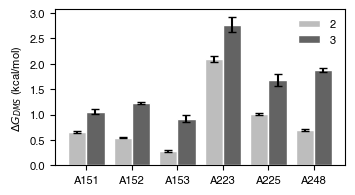

In [14]:
sites = {151: 'A151', 152: 'A152', 153: 'A153', 223: 'A223', 225: 'A225', 248: 'A248'}
barplot_dG(df_main_AC, sites)

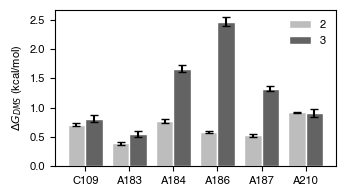

In [16]:
sites = {183: 'A183', 184: 'A184', 186: 'A186', 187: 'A187', 109: 'C109', 210: 'A210', 211: 'C211'}
barplot_dG(df_main_AC, sites)